In [132]:
import os
import numpy as np
import matplotlib.pyplot as plt
import wfdb
from physio import respiration
import neurokit2 as nk
from scipy.interpolate import interp1d, CubicSpline
import torch
from customLib.preprocess import *
from customLib.config import fantasia_path, fantasia_sampling_rate
from models.models import SimpleTransformerModel
from customLib.peak_detection import find_mean_avg_r_peak_indices, detect_nk

### Fantasia dataset

In [21]:
SIGNALS = ["ECG", "RESP"]
fileNames = [ x.split(".")[0] for x in os.listdir(fantasia_path) if x.endswith("ecg") ]

file = fantasia_path + "\\" + fileNames[1]

record = wfdb.rdrecord(file)
annotation = wfdb.rdann(file, extension="ecg")

R_wave = np.zeros_like(record.p_signal[:,1])
R_wave[annotation.sample] = 1


### Own dataset

In [133]:
aidmed_ecg_sampling_rate = 250
aidmed_resp_sampling_rate = 50

path = "E:\\ml-data\\masters-thesis\\myDataset\\Patryk\\ecg_with_resp"

ecg = np.load(os.path.join(path, "6_ecg.npy"))
resp = np.load(os.path.join(path, "6_resp.npy"))

ecg_first_timestep = ecg[0][1]
ecg_last_timestep = ecg[-1][1]

resp_first_timestep = resp[0][1]
resp_last_timestep = resp[-1][1]

print("First ecg time stamp: ", ecg_first_timestep)
print("First respiration time stamp: ", resp_first_timestep)

print("Last ecg time stamp: ", ecg_last_timestep)
print("Last respiration time stamp", resp_last_timestep)

First ecg time stamp:  1726498747293.0
First respiration time stamp:  1726498747293.0
Last ecg time stamp:  1726498780284.0
Last respiration time stamp 1726498780284.0


In [134]:
resp = resp[:, 0]
try:
    assert ecg_first_timestep == resp_first_timestep, "start-mismatch" # check whether the ecg and resp recording started at the same sample
    assert ecg_last_timestep == resp_last_timestep, "end-mismatch" # check whether the ecg and resp recording ended at the same sample
except AssertionError as e:
    if str(e) == "start-mismatch":
        #raise Exception("The start time of ECG and RESP recordings do not match.")
        mismatch_idx = int(np.where(resp_first_timestep == ecg[:,1])[0])
        ecg = ecg[mismatch_idx:, 0]
    elif str(e) == "end-mismatch":
        #raise Exception("The end time of ECG and RESP recordings do not match.")
        mismatch_idx = int(np.where(resp_last_timestep == ecg[:,1])[0])
        ecg = ecg[:mismatch_idx, 0]
    else:
        raise Exception("An unknown data time stamp mismatch occurred.")
finally:
    ecg = ecg[:,0]

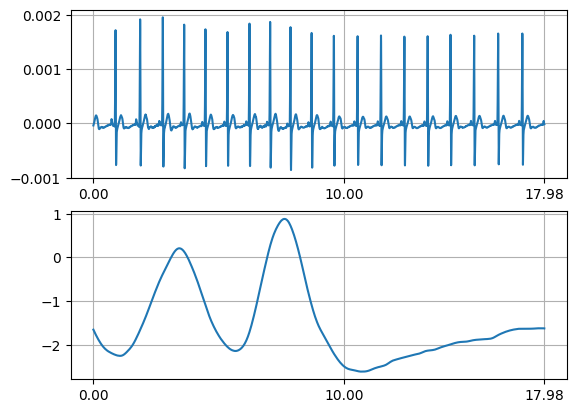

In [135]:
seconds = 60
ecg_recording_length = seconds * aidmed_ecg_sampling_rate
resp_recording_length = seconds * aidmed_resp_sampling_rate

start = 15 * aidmed_ecg_sampling_rate
stop = ecg_recording_length + start

# ecg = record.p_signal[:,1]
ecg = ecg[start:stop]

start = 15 * aidmed_resp_sampling_rate
stop = resp_recording_length + start

# resp = record.p_signal[:,0]
resp = resp[start:stop]

t_ecg = [x * 1/aidmed_ecg_sampling_rate for x in range(ecg.shape[0])]
t_resp = [x * 1/aidmed_resp_sampling_rate for x in range(resp.shape[0])]

t_ticks_ecg = [x for x in t_ecg if x%10 == 0] + [t_ecg[-1]]
t_ticks_resp = [x for x in t_resp if x%10 == 0] + [t_resp[-1]]

fig, axs = plt.subplots(nrows=2)

ax = axs[0]
ax.plot(t_ecg, ecg)
ax.grid()
ax.set_xticks(t_ticks_ecg)

ax = axs[1]
ax.plot(t_resp, resp)
ax.grid()
ax.set_xticks(t_ticks_resp)


In [129]:
# smoothening
resp = myConv1D(signal=resp, kernel_length=5, padding="same")
ecg = myConv1D(signal=ecg, kernel_length=5, padding="same")

# wavelet denoise
ecg = dwt_denoise(signal=ecg)

#normalization
resp = norm_min_max(resp, -1, 1)
ecg = norm_min_max(ecg, -1, 1)

# neurokit for r_peaks detection
R_wave_indices = detect_nk(ecg, fs=aidmed_ecg_sampling_rate)
R_wave = np.zeros_like(ecg)
R_wave[R_wave_indices] = 1
R_wave_time = R_wave_indices * 1 / aidmed_ecg_sampling_rate


# R_wave = R_wave[:recording_length]
# R_wave_indices = np.where(R_wave == 1)[0]
# R_wave_time = R_wave_indices * 1/fantasia_sampling_rate

rr_intervals  = np.diff(R_wave_indices) * 1/fantasia_sampling_rate * 1000

rr_times = R_wave_time[:-1] - R_wave_time[0]

t_resampled = np.arange(0, rr_times[-1], 0.1)

rr_interpolator = CubicSpline(rr_times, rr_intervals)
rr_interpolated = rr_interpolator(t_resampled)

rr_interpolated = norm_min_max(rr_interpolated, -1 , 1)

rpa = ecg[R_wave_indices]
rpa_t = R_wave_time - R_wave_time[0]

rpa_t_resampled = np.arange(0, rpa_t[-1], 0.1)

rpa_interpolator = CubicSpline(rpa_t, rpa)
rpa_interpolated = rpa_interpolator(rpa_t_resampled)

rpa_interpolated = norm_min_max(rpa_interpolated, -1 , 1)

peaks = nk.ecg_findpeaks(ecg_cleaned=ecg, sampling_rate=250)["ECG_R_Peaks"]

ecg_rate = nk.ecg_rate(peaks=R_wave_indices, sampling_rate=250, desired_length=len(ecg))
edr = nk.ecg_rsp(ecg_rate=ecg_rate, sampling_rate=250)

clean_resp = nk.rsp.rsp_clean(resp, sampling_rate=250)
resp_peaks = nk.rsp_findpeaks(clean_resp, sampling_rate=250)['RSP_Peaks']

resp_df = respiration.compute_respiration(clean_resp, 250)
inspi_indices = resp_df[1]['inspi_index']

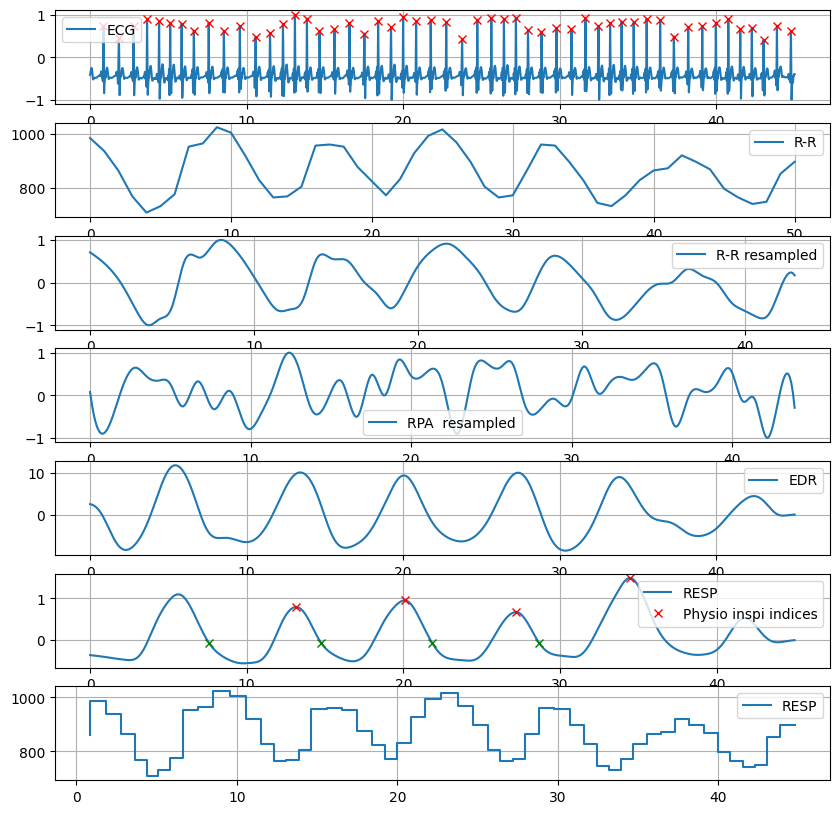

In [130]:
t = [x * 1/aidmed_ecg_sampling_rate for x in range(ecg.shape[0])]

fig, axs = plt.subplots(nrows=7)

ax = axs[0]
ax.plot(t, ecg)
ax.plot(peaks * 1/fantasia_sampling_rate, ecg[peaks], 'rx')
ax.grid()
ax.legend(["ECG"])

ax = axs[1]
ax.plot(rr_intervals)
ax.grid()
ax.legend(["R-R"])

ax = axs[2]
ax.plot(t_resampled, rr_interpolated)
ax.grid()
ax.legend(["R-R resampled"])

ax = axs[3]
ax.plot(rpa_t_resampled, rpa_interpolated)
ax.grid()
ax.legend(["RPA  resampled"])

ax = axs[4]
ax.plot(t, edr)
ax.grid()
ax.legend(["EDR"])

ax = axs[5]
ax.plot(t_resp, clean_resp)
ax.plot(resp_peaks * 1/aidmed_resp_sampling_rate, clean_resp[resp_peaks], 'rx')
ax.plot(inspi_indices * 1/aidmed_resp_sampling_rate, clean_resp[inspi_indices], 'gx')
ax.grid()
ax.legend(["RESP", "Neurokit resp indices"])
ax.legend(["RESP", "Physio inspi indices"])

ax = axs[6]
ax.step(R_wave_time, [np.mean(rr_intervals)] + rr_intervals.tolist())
ax.grid()
ax.legend(["RESP", "Physio inspi indices"])

fig.set_size_inches(10,10)


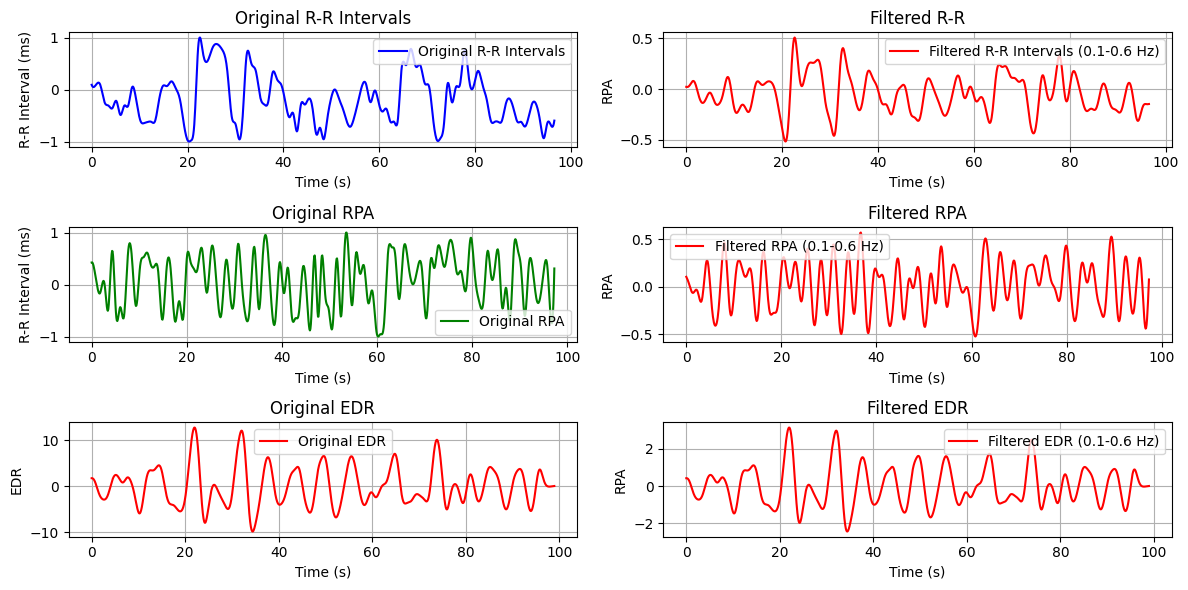

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firls, filtfilt
from scipy.signal.windows import hamming
from scipy.interpolate import CubicSpline

# Define the FIR filter design function with window
def fir_least_squares_bandpass_with_window(lowcut, highcut, fs, numtaps):
    # Normalize the cutoff frequencies
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Define the desired frequency response
    bands = [0, low, low, high, high, 1]
    desired = [0, 0, 1, 1, 0, 0]
    
    # Create the FIR filter using firls (least-squares method)
    taps = firls(numtaps, bands, desired)
    
    # Apply Hamming window to the FIR filter coefficients
    window = hamming(numtaps)
    taps *= window
    
    return taps

# Apply the FIR filter to the data (standard filtering)
def apply_zero_phase_filter(data, taps):
    return filtfilt(taps, 1.0, data)

# Example R-R interval signal (resampled at 4 Hz)
fs = 10  # Sampling frequency (Hz)
numtaps = 51  # Number of filter taps (odd number for FIR filter)
lowcut = 0.1  # Low cutoff frequency (Hz)
highcut = 0.5  # High cutoff frequency (Hz)

# Design the least-squares FIR bandpass filter with window
taps = fir_least_squares_bandpass_with_window(lowcut, highcut, fs, numtaps)

# Apply the zero-phase FIR filter
filtered_rr_intervals = apply_zero_phase_filter(rr_interpolated, taps)
filtered_rpa = apply_zero_phase_filter(rpa_interpolated, taps)
filtered_edr = apply_zero_phase_filter(edr, taps)

# Plot original and filtered signal
plt.figure(figsize=(12, 6))

plt.subplot(3, 2, 1)
plt.plot(t_resampled, rr_interpolated, 'b-', label='Original R-R Intervals')
plt.title('Original R-R Intervals')
plt.xlabel('Time (s)')
plt.ylabel('R-R Interval (ms)')
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(rpa_t_resampled, rpa_interpolated, 'g-', label='Original RPA')
plt.title('Original RPA')
plt.xlabel('Time (s)')
plt.ylabel('R-R Interval (ms)')
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(t, edr, 'r-', label='Original EDR')
plt.title('Original EDR')
plt.xlabel('Time (s)')
plt.ylabel('EDR')
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(t_resampled, filtered_rr_intervals, 'r-', label='Filtered R-R Intervals (0.1-0.6 Hz)')
plt.title('Filtered R-R')
plt.xlabel('Time (s)')
plt.ylabel('RPA')
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(rpa_t_resampled, filtered_rpa, 'r-', label='Filtered RPA (0.1-0.6 Hz)')
plt.title('Filtered RPA')
plt.xlabel('Time (s)')
plt.ylabel('RPA')
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(t, filtered_edr, 'r-', label='Filtered EDR (0.1-0.6 Hz)')
plt.title('Filtered EDR')
plt.xlabel('Time (s)')
plt.ylabel('RPA')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


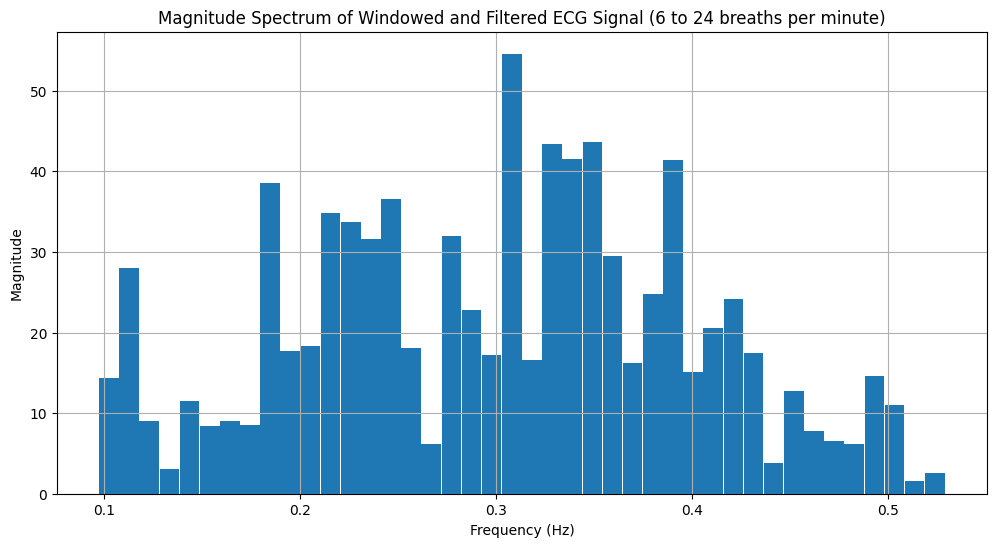

Respiratory rate frequency:  0.3080082135523614 Breaths per minute:  18.480492813141684


In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter

# # Example parameters
sampling_rate = 10  # Hz
signal_length = len(filtered_rpa) # Number of samples (60 seconds)

# # Step 1: Design a FIR band-pass filter
# # Pass band range: 0.1 to 1 Hz
# low_cutoff = 0.1  # Hz
# high_cutoff = 1.0  # Hz
# numtaps = 101  # Number of filter taps

# # Design the filter
# fir_coeff = firwin(numtaps, [low_cutoff, high_cutoff], fs=sampling_rate, pass_zero=False)

# # Step 2: Apply the FIR band-pass filter
# ecg_filtered = lfilter(fir_coeff, 1.0, ecg)

# # Step 3: Create a Hamming window
# hamming_window = np.hamming(signal_length)

# # Step 4: Apply the Hamming window to the filtered ECG signal
# ecg_windowed = ecg_filtered * hamming_window

# Step 5: Compute the FFT of the windowed signal
ecg_fft_windowed = np.fft.fft(filtered_rpa)

# Step 6: Compute the magnitude spectrum
ecg_magnitude_windowed = np.abs(ecg_fft_windowed)

# Step 7: Define the frequency axis
frequencies = np.fft.fftfreq(signal_length, d=1/sampling_rate)

# Step 8: Convert breaths per minute to Hz
breaths_per_minute_min = 6
breaths_per_minute_max = 32

frequency_min = breaths_per_minute_min / 60  # Convert BPM to Hz
frequency_max = breaths_per_minute_max / 60  # Convert BPM to Hz

# Find the indices corresponding to the desired frequency range
positive_freq_indices = np.where(frequencies >= 0)
frequencies_positive = frequencies[positive_freq_indices]
magnitude_positive = ecg_magnitude_windowed[positive_freq_indices]

# Find the range of indices corresponding to the desired frequency range
freq_indices = (frequencies_positive >= frequency_min) & (frequencies_positive <= frequency_max)
frequencies_range = frequencies_positive[freq_indices]
magnitude_range = magnitude_positive[freq_indices]

max_idx = np.argmax(magnitude_range)
rr_freq = frequencies_range[max_idx]

# Plot the magnitude spectrum for the specified frequency range
plt.figure(figsize=(12, 6))
plt.bar(frequencies_range, magnitude_range, width=0.01)
#plt.plot(rr_freq, magnitude_range[max_idx], 'rx')
plt.title('Magnitude Spectrum of Windowed and Filtered ECG Signal (6 to 24 breaths per minute)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

print("Respiratory rate frequency: ", rr_freq, "Breaths per minute: ", rr_freq * 60)


In [36]:
magnitude_range

array([ 5340.60117219,  7090.70699047, 10877.34273036, 18440.91845326,
       20237.81012295, 14979.2526715 , 21494.3164163 ,  6696.43169817,
        6774.59952707,  1701.62950077,  3835.33456667,  4479.06861415,
        1604.05121682,  3642.08170919,  1637.45895684,  5033.93845255,
        4061.53381444,  3505.30768875,   730.60717107,  3442.43665259,
        1375.53037008,   298.11420776,   719.65062599,   288.41701401,
         639.70150394,   834.17747051])

In [37]:
frequencies_range

array([0.10038817, 0.11711953, 0.13385089, 0.15058225, 0.16731361,
       0.18404497, 0.20077634, 0.2175077 , 0.23423906, 0.25097042,
       0.26770178, 0.28443314, 0.3011645 , 0.31789586, 0.33462723,
       0.35135859, 0.36808995, 0.38482131, 0.40155267, 0.41828403,
       0.43501539, 0.45174675, 0.46847812, 0.48520948, 0.50194084,
       0.5186722 ])